
---
# SAiDL Spring 2025 Induction Assignment: CoreML
---

## Table of Contents

### 1. Setting up the Environment
- [1.1 Importing the necessary packages](#11-importing-the-necessary-packages)  
- [1.2 Fixing the seed to ensure reproducability](#12-fixing-the-seed-to-ensure-reproducability)  
- [1.3 Detecting the GPU](#13-detecting-the-gpu)  

### 2. Setting up the Experiment
- [2.1 Configuring the noise and loss parameters](#21-configuring-the-noise-and-loss-parameters)  
- [2.2 Helper functions to noisify the data](#22-helper-functions-to-noisify-the-data)  
- [2.3 Wrapping the data into dataloaders](#23-wrapping-the-data-into-dataloaders)  
- [2.4 Defining the losses](#24-defining-the-losses) 

### 3. Developing the Model
- [3.1 Building the model](#31-building-the-model)  
- [3.2 Helper function to train the model](#32-helper-function-to-train-the-model)  
- [3.3 Helper function to evaluate the model](#33-helper-function-to-evaluate-the-model)  
- [3.4 The Training Process](#34-the-training-process)  

### 4. Capturing the Performance
- [4.1 Validation loss and accuracy vs epochs](#41-validation-loss-and-accuracy-vs-epochs)  
- [4.2 Comparing the noises and losses](#42-comparing-the-noises-and-losses)  

# 1. Setting up the Environment
---

## 1.1 Importing the Necessary Packages

In [31]:
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

from torch.utils.data import DataLoader, Dataset

## 1.2 Fixing the Seed to ensure Reproducability

In [32]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 

## 1.3 Detecting the GPU

In [33]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
    scaler = torch.amp.GradScaler()
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")

Using device: cuda


# 2. Setting up the Experiment
---

## 2.1 Configuring the Noise and Loss Parameters

In [49]:
num_classes = 10
data_root = './data' 

symmetric_noise_rates = [0.0, 0.2, 0.5, 0.8] 

asymmetric_noise_rates = [0.0, 0.1, 0.25, 0.4] 
asymmetric_transitions = {
    9: 1,  # Truck -> Automobile
    2: 0,  # Bird -> Airplane
    4: 7,  # Deer -> Horse
    3: 5,  # Cat -> Dog
    5: 3   # Dog -> Cat
}

num_epochs = 30
batch_size = 128
learning_rate = 0.01 
weight_decay = 5e-4
lr_gamma = 0.1  

losses = ['CE', 'FL', 'NCE', 'NFL', 'APL-NCE-MAE', 'APL-NFL-MAE']

fl_alpha = 1.0 
fl_gamma = 2.0 
apl_alpha = 1.0 
apl_beta = 1.0   

results = defaultdict(lambda: defaultdict(dict)) 

## 2.2 Helper functions to Noisify the Data

In [35]:
def noisify_symmetric(labels, noise_rate, num_classes):
    """
    Applies symmetric label noise by randomly flipping a fraction of labels to any other class.
    """
    if noise_rate == 0.0:
        return labels.copy() 

    noisy_labels = labels.copy()
    num_samples = len(labels)
    num_noisy = int(noise_rate * num_samples)

    noisy_indices = np.random.choice(num_samples, num_noisy, replace=False)

    for i in noisy_indices:
        original_label = labels[i]
        new_label = np.random.randint(0, num_classes)
        while new_label == original_label:
            new_label = np.random.randint(0, num_classes)
        noisy_labels[i] = new_label

    print(f"Applied symmetric noise rate: {noise_rate:.2f}. Flipped {len(noisy_indices)} labels.")
    return noisy_labels
    

def noisify_asymmetric(labels, noise_rate, transitions, num_classes):
    """
    Applies asymmetric label noise by flipping labels according to a transition map,
    with a small amount of uniform noise for other non-specified classes.
    """
    if noise_rate == 0.0:
        return labels.copy() 

    noisy_labels = labels.copy()
    num_samples = len(labels)
    num_noisy = 0
    uniform_noise_rate = noise_rate * 0.1  

    for i in range(num_samples):
        original_label = labels[i]
        if original_label in transitions:
            if np.random.rand() < noise_rate:
                noisy_labels[i] = transitions[original_label]
                num_noisy += 1
        else:
            if np.random.rand() < uniform_noise_rate:
                possible_labels = [l for l in range(num_classes) if l != original_label]
                noisy_labels[i] = np.random.choice(possible_labels)
                num_noisy += 1

    print(f"Applied asymmetric noise rate: {noise_rate:.2f} and uniform noise rate: {uniform_noise_rate:.2f}. Flipped {num_noisy} labels.")
    return noisy_labels

## 2.3 Wrapping the Data into DataLoaders

In [36]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])


class NoisyCIFAR10(Dataset):
    """
    A custom Dataset wrapper for CIFAR-10 that replaces ground truth labels with noisy labels while preserving access to original targets.
    """
    def __init__(self, cifar_dataset, noisy_labels):
        self.cifar_dataset = cifar_dataset
        self.noisy_labels = noisy_labels
        if hasattr(self.cifar_dataset, 'dataset'):
            base_dataset = self.cifar_dataset.dataset
            indices = self.cifar_dataset.indices
            if isinstance(base_dataset.targets, list):
                self.original_targets = np.array(base_dataset.targets)[indices]
            else:
                self.original_targets = base_dataset.targets[indices]
        else:
            if isinstance(self.cifar_dataset.targets, list):
                self.original_targets = np.array(self.cifar_dataset.targets)
            else:
                self.original_targets = self.cifar_dataset.targets
        if len(self.noisy_labels) != len(self.cifar_dataset):
            raise ValueError("Length of noisy labels must match dataset size")
    def __getitem__(self, index):
        img, _ = self.cifar_dataset[index]
        noisy_label = self.noisy_labels[index]
        return img, noisy_label
    def __len__(self):
        return len(self.cifar_dataset)
        

def get_dataloaders(noise_type, noise_rate, batch_size, data_root='./data', validation_split=0.15, num_classes=10, asymmetric_transitions=None):
    """
    Creates and returns DataLoaders for training, validation, and test datasets using CIFAR-10,
    with label noise injected into the training data (either symmetric or asymmetric).
    """
    cifar_train = CIFAR10(root=data_root, train=True, download=True, transform=transform_train)
    test_dataset = CIFAR10(root=data_root, train=False, download=True, transform=transform_test)
    
    if isinstance(cifar_train.targets, list):
        original_train_labels = np.array(cifar_train.targets)
    else:
        original_train_labels = cifar_train.targets
        
    num_train = len(cifar_train)
    indices = np.arange(num_train)
    np.random.shuffle(indices)
    split = int(np.floor(validation_split * num_train))
    
    val_indices = indices[:split]
    train_indices = indices[split:]
    train_subset = Subset(cifar_train, train_indices)
    val_subset = Subset(cifar_train, val_indices)
    train_clean_labels = original_train_labels[train_indices]
    
    if noise_type == 'symmetric':
        noisy_train_labels = noisify_symmetric(train_clean_labels, noise_rate, num_classes)
    elif noise_type == 'asymmetric':
        noisy_train_labels = noisify_asymmetric(train_clean_labels, noise_rate, asymmetric_transitions, num_classes)
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")
        
    train_dataset_noisy = NoisyCIFAR10(train_subset, noisy_train_labels)
    train_loader = DataLoader(train_dataset_noisy, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader

## 2.4 Defining the Losses

In [37]:
criterion_ce = nn.CrossEntropyLoss()

class FocalLoss(nn.Module):
    """
    Focal Loss for classification tasks to address class imbalance by focusing more on hard examples with adjustable alpha and gamma.
    """
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.reduction = reduction

    def forward(self, inputs, targets):
        probs = F.softmax(inputs, dim=-1)
        ce_loss = F.cross_entropy(inputs, targets.long(), reduction='none')
        p_t = torch.gather(probs, 1, targets.unsqueeze(1)).squeeze(1)

        modulating_factor = (1 - p_t) ** self.gamma
        focal_loss = self.alpha * modulating_factor * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss
criterion_fl = FocalLoss(alpha=fl_alpha, gamma=fl_gamma)


class NormalizedLoss(nn.Module):
    def __init__(self, base_loss_fn, T=1.0):
        super(NormalizedLoss, self).__init__()
        self.base_loss_fn = base_loss_fn
        self.T = T
        if hasattr(self.base_loss_fn, 'reduction'):
            self.base_reduction = self.base_loss_fn.reduction
        else:
             self.base_reduction = 'mean'

    def forward(self, inputs, targets):
        base_loss = self.base_loss_fn(inputs, targets)
        normalized_loss = 1. - torch.exp(-base_loss / self.T)

        return normalized_loss

criterion_ce_for_nce = nn.CrossEntropyLoss(reduction='mean') 
criterion_nce = NormalizedLoss(criterion_ce_for_nce, T=1.0)

criterion_fl_for_nfl = FocalLoss(alpha=fl_alpha, gamma=fl_gamma, reduction='mean') 
criterion_nfl = NormalizedLoss(criterion_fl_for_nfl, T=1.0)


class MAELoss(nn.Module):
    """
    Mean Absolute Error loss for classification, computed between predicted probabilities and one-hot encoded ground truths.
    """
    def __init__(self, num_classes, scale=1.0):
        super().__init__()
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred_probs = F.softmax(pred, dim=1)
        
        label_one_hot = F.one_hot(labels, self.num_classes).float().to(pred.device)
        
        mae_per_sample = torch.abs(label_one_hot - pred_probs).mean(dim=1)
        return self.scale * mae_per_sample.mean()
criterion_mae = MAELoss(num_classes=num_classes)


class APL_Loss(nn.Module):
    def __init__(self, active_loss_fn, passive_loss_fn, alpha=1.0, beta=1.0):
        super(APL_Loss, self).__init__()
        self.active_loss_fn = active_loss_fn
        self.passive_loss_fn = passive_loss_fn
        self.alpha = alpha
        self.beta = beta

    def forward(self, inputs, targets):
        active_loss = self.active_loss_fn(inputs, targets)
        passive_loss = self.passive_loss_fn(inputs, targets)
        total_loss = self.alpha * active_loss + self.beta * passive_loss
        return total_loss

criterion_apl_nce_mae = APL_Loss(criterion_nce, criterion_mae, alpha=apl_alpha, beta=apl_beta)
criterion_apl_nfl_mae = APL_Loss(criterion_nfl, criterion_mae, alpha=apl_alpha, beta=apl_beta)

loss_functions = {
    'CE': criterion_ce,
    'FL': criterion_fl,
    'NCE': criterion_nce,
    'NFL': criterion_nfl,
    'APL-NCE-MAE': criterion_apl_nce_mae,
    'APL-NFL-MAE': criterion_apl_nfl_mae,
}

# 3. Developing the Model
---

## 3.1 Building the Model

In [38]:
def build_model(num_classes=10, pretrained=False):
    """
    Builds a ResNet18 model, optionally with pretrained ImageNet weights, and replaces the final fully connected layer for classification.
    """
    weights = torchvision.models.ResNet18_Weights.DEFAULT if pretrained else None
    model = torchvision.models.resnet18(weights=weights)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

## 3.2 Helper function to Train the Model

In [39]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """
    Trains and evaluates the model for one epoch using the given criterion, optimizer, and data loaders, returning losses and accuracies.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:
            elapsed_time = time.time() - start_time
            print(f'Epoch: {epoch+1}/{num_epochs} | Batch: {batch_idx+1}/{len(train_loader)} | Train Loss: {loss.item():.4f} | Train Acc: {100.*correct/total:.2f}% | Time: {elapsed_time:.2f}s')
            
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad(): 
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)

            outputs = model(inputs)
            loss = criterion(outputs, targets) 

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss = running_loss / total
    val_acc = 100. * correct / total
    elapsed_time = time.time() - start_time
    print(f'--- Epoch {epoch+1} Finished ---')
    print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.2f}% | Time: {elapsed_time:.2f}s')
    print()

    return epoch_loss, epoch_acc, val_loss, val_acc

## 3.3 Helper function to Evaluate the Model

In [40]:
def evaluate(model, test_loader, criterion, device):
    """
    Evaluates the model on the given test dataset and returns the loss and accuracy.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad(): 
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)

            outputs = model(inputs)
            loss = criterion(outputs, targets) 

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = running_loss / total
    test_acc = 100. * correct / total
    elapsed_time = time.time() - start_time
    print(f'Evaluation Results -- Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}% | Time: {elapsed_time:.2f}s')
    print()
    
    return test_loss, test_acc

## 3.4 The Training Process

In [50]:
print("="*60)
print("Starting Experiments...")
print("="*60)

all_noise_types = {
    'symmetric': symmetric_noise_rates,
    'asymmetric': asymmetric_noise_rates
}

experiment_start_time = time.time()

val_metrics = {
    'symmetric': {loss_name: {rate: {'loss': [], 'acc': []} for rate in symmetric_noise_rates} for loss_name in losses},
    'asymmetric': {loss_name: {rate: {'loss': [], 'acc': []} for rate in asymmetric_noise_rates} for loss_name in losses}
}

for noise_type, noise_rates in all_noise_types.items():
    print(f"\n===== Running Experiments for Noise Type: {noise_type.upper()} =====")
    for loss_name in losses:
        print(f"\n----- Training with Loss: {loss_name} -----")
        for noise_rate in noise_rates:
            print(f"\n--- Noise Rate: {noise_rate:.2f} ---")

            print("Preparing Dataloaders...")
            train_loader, val_loader, test_loader = get_dataloaders(noise_type, noise_rate, batch_size, data_root, asymmetric_transitions=asymmetric_transitions)
            print()

            print("Initializing Model and Optimizer...")
            model = build_model(num_classes=num_classes).to(device)
            criterion = loss_functions[loss_name].to(device)
            optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate * 1e-2)
            print()

            print("Starting Training...")
            best_val_acc = 0.0
            for epoch in range(num_epochs):
                train_loss, train_acc,val_loss, val_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
                scheduler.step() 
                val_metrics[noise_type][loss_name][noise_rate]['loss'].append(val_loss)
                val_metrics[noise_type][loss_name][noise_rate]['acc'].append(val_acc)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    torch.save(model.state_dict(), f"best_model_{noise_type}_{loss_name}_{noise_rate:.1f}.pth")

            print(f"--- Finished Training for {loss_name} at Noise Rate {noise_rate:.2f} ---")
            print(f"Best Val Accuracy achieved: {best_val_acc:.2f}%")
            test_loss, test_acc = evaluate(model, test_loader, criterion, device)
            print(f"Test Accuracy achieved: {test_acc:.2f}%")

            results[noise_type][loss_name][noise_rate] = test_acc
            results_list = [{
                'Noise Type': noise_type,
                'Loss Function': loss_name,
                'Noise Rate': noise_rate,
                'Test Accuracy': test_acc
            }]

            csv_path = "/home/user/Music/dont_touch/indic/results.csv"
            try:
                existing_df = pd.read_csv(csv_path)
                updated_df = pd.concat([existing_df, pd.DataFrame(results_list)], ignore_index=True)
            except FileNotFoundError:
                updated_df = pd.DataFrame(results_list)

            updated_df.to_csv(csv_path, index=False)
            print("✅ Partial result saved to results.csv")

            del model, optimizer, scheduler, train_loader, val_loader, test_loader
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                

experiment_end_time = time.time()
print("\n" + "="*60)
print(f"All Experiments Completed in {(experiment_end_time - experiment_start_time)/3600:.2f} hours")
print("="*60)

Starting Experiments...

===== Running Experiments for Noise Type: SYMMETRIC =====

----- Training with Loss: CE -----

--- Noise Rate: 0.00 ---
Preparing Dataloaders...

Initializing Model and Optimizer...

Starting Training...
Epoch: 1/30 | Batch: 100/333 | Train Loss: 1.9931 | Train Acc: 21.39% | Time: 2.13s
Epoch: 1/30 | Batch: 200/333 | Train Loss: 2.0580 | Train Acc: 25.56% | Time: 4.05s
Epoch: 1/30 | Batch: 300/333 | Train Loss: 1.7531 | Train Acc: 28.39% | Time: 6.12s
--- Epoch 1 Finished ---
Val Loss: 2.1887 | Val Accuracy: 29.24% | Time: 1.43s

Epoch: 2/30 | Batch: 100/333 | Train Loss: 1.7334 | Train Acc: 32.44% | Time: 2.52s
Epoch: 2/30 | Batch: 200/333 | Train Loss: 1.6107 | Train Acc: 35.70% | Time: 4.53s
Epoch: 2/30 | Batch: 300/333 | Train Loss: 1.7089 | Train Acc: 37.93% | Time: 6.50s
--- Epoch 2 Finished ---
Val Loss: 7.8993 | Val Accuracy: 24.39% | Time: 1.49s

Epoch: 3/30 | Batch: 100/333 | Train Loss: 1.6887 | Train Acc: 28.79% | Time: 2.49s
Epoch: 3/30 | Batch: 20

# 4. Capturing the Performance
---

## 4.1 Validation Loss and Accuracy vs Epochs

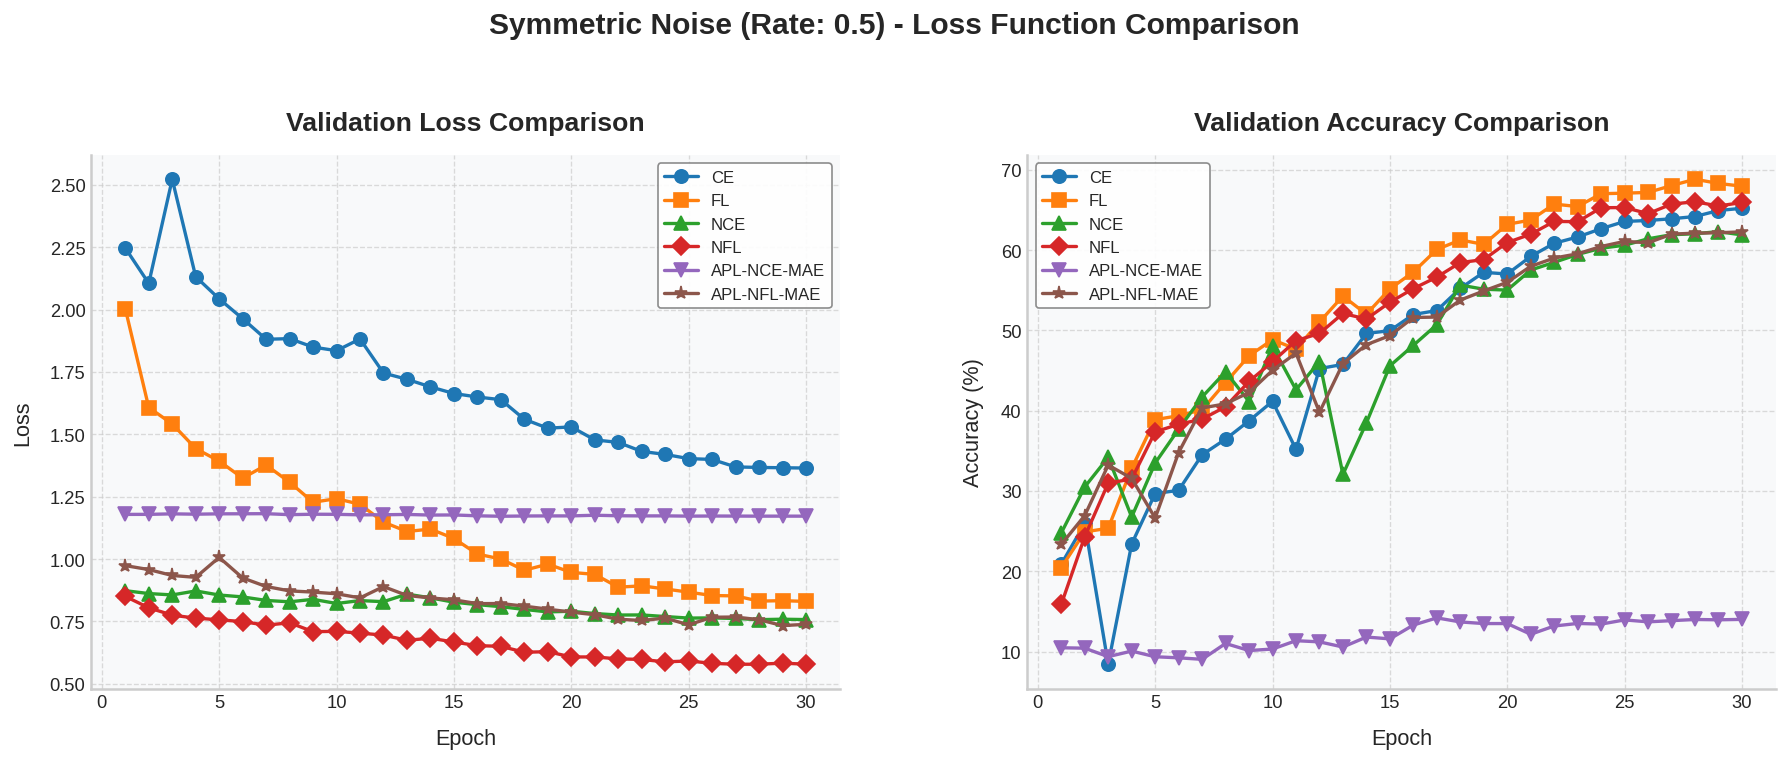

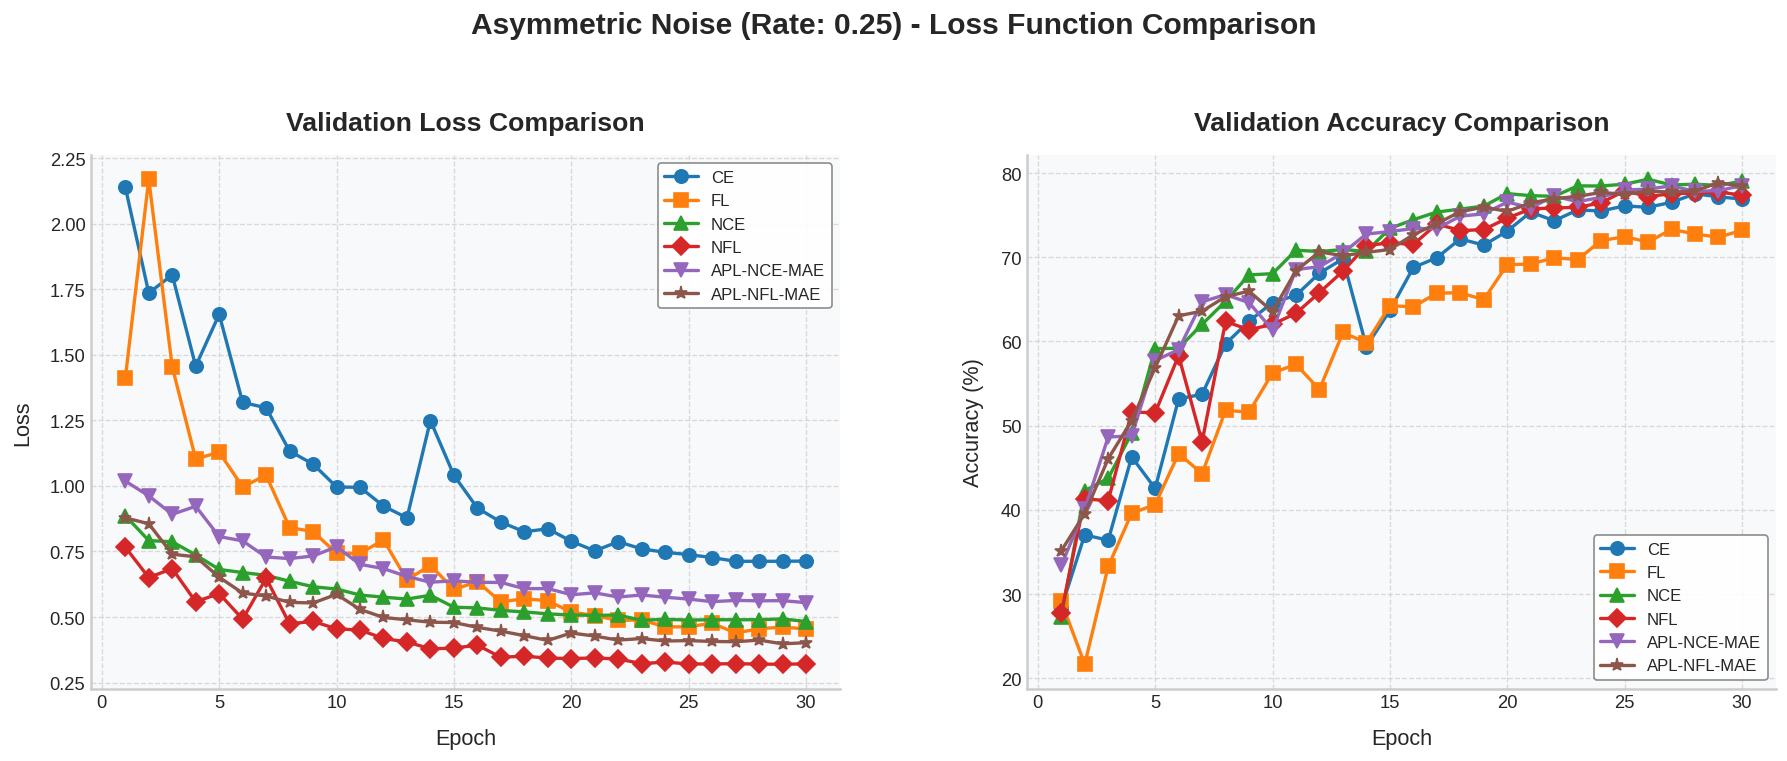

In [53]:
symmetric_noise_rate = 0.5 
asymmetric_noise_rate = 0.25 

def plot_loss_function_comparison(noise_type, noise_rate, val_metrics):
    """
    Creates comparison plots for multiple loss functions at a specific noise setting.
    """
    plt.figure(figsize=(15, 6), dpi=120, facecolor='white')
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    markers = ['o', 's', '^', 'D', 'v', '*']
    line_width = 2.0
    marker_size = 8
    spine_width = 1.5
    
    ax1 = plt.subplot(1, 2, 1)
    
    for i, loss_name in enumerate(losses):
        loss_data = val_metrics[noise_type][loss_name][noise_rate]['loss']
        epochs = range(1, len(loss_data) + 1)
        
        plt.plot(
            epochs, 
            loss_data, 
            marker=markers[i % len(markers)],
            linestyle='-',
            linewidth=line_width,
            markersize=marker_size,
            markerfacecolor=colors[i % len(colors)],
            markeredgecolor=colors[i % len(colors)],
            color=colors[i % len(colors)],
            label=loss_name,
            zorder=5
        )
    
    plt.title(f'Validation Loss Comparison', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Epoch', fontsize=13, labelpad=10)
    plt.ylabel('Loss', fontsize=13, labelpad=10)
    plt.grid(axis='both', linestyle='--', alpha=0.7, zorder=0)
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(spine_width)
    ax1.spines['bottom'].set_linewidth(spine_width)
    ax1.tick_params(axis='both', which='major', labelsize=11)
    ax1.set_facecolor('#f8f9fa')
    
    plt.legend(fontsize=10, frameon=True, framealpha=0.9, edgecolor='gray')
    
    ax2 = plt.subplot(1, 2, 2)
    
    for i, loss_name in enumerate(losses):
        acc_data = val_metrics[noise_type][loss_name][noise_rate]['acc']
        epochs = range(1, len(acc_data) + 1)
        
        plt.plot(
            epochs, 
            acc_data, 
            marker=markers[i % len(markers)],
            linestyle='-',
            linewidth=line_width,
            markersize=marker_size,
            markerfacecolor=colors[i % len(colors)],
            markeredgecolor=colors[i % len(colors)],
            color=colors[i % len(colors)],
            label=loss_name,
            zorder=5
        )
    
    plt.title(f'Validation Accuracy Comparison', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Epoch', fontsize=13, labelpad=10)
    plt.ylabel('Accuracy (%)', fontsize=13, labelpad=10)
    plt.grid(axis='both', linestyle='--', alpha=0.7, zorder=0)
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(spine_width)
    ax2.spines['bottom'].set_linewidth(spine_width)
    ax2.tick_params(axis='both', which='major', labelsize=11)
    ax2.set_facecolor('#f8f9fa')
    
    plt.legend(fontsize=10, frameon=True, framealpha=0.9, edgecolor='gray')
    
    plt.suptitle(f'{noise_type.capitalize()} Noise (Rate: {noise_rate}) - Loss Function Comparison', fontsize=18, fontweight='bold', y=1.05)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)
    
    plt.savefig(f'loss_comparison_{noise_type}_rate_{noise_rate}.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_loss_function_comparison('symmetric', symmetric_noise_rate, val_metrics)
plot_loss_function_comparison('asymmetric', asymmetric_noise_rate, val_metrics)

## 4.2 Comparing the Noises and Losses

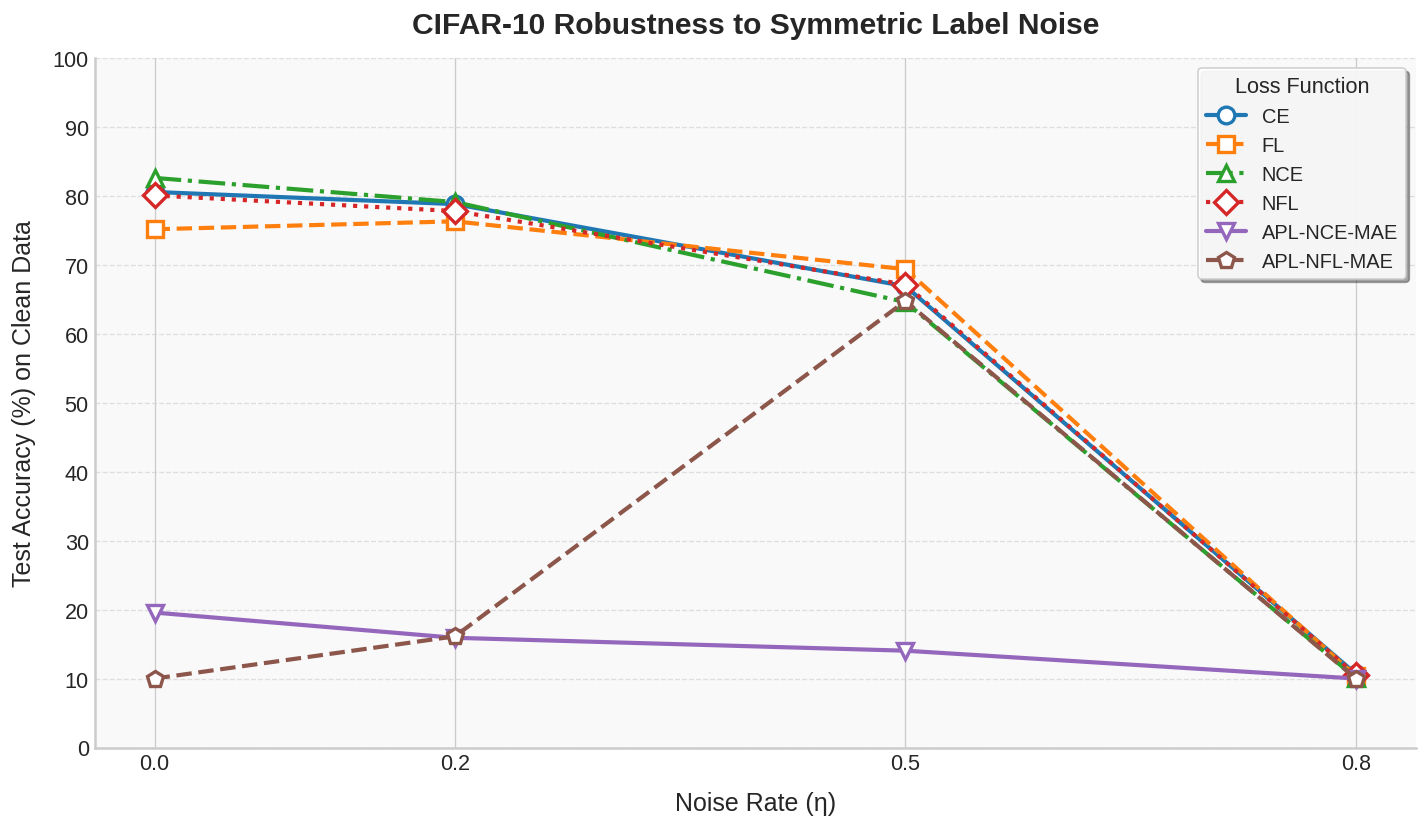

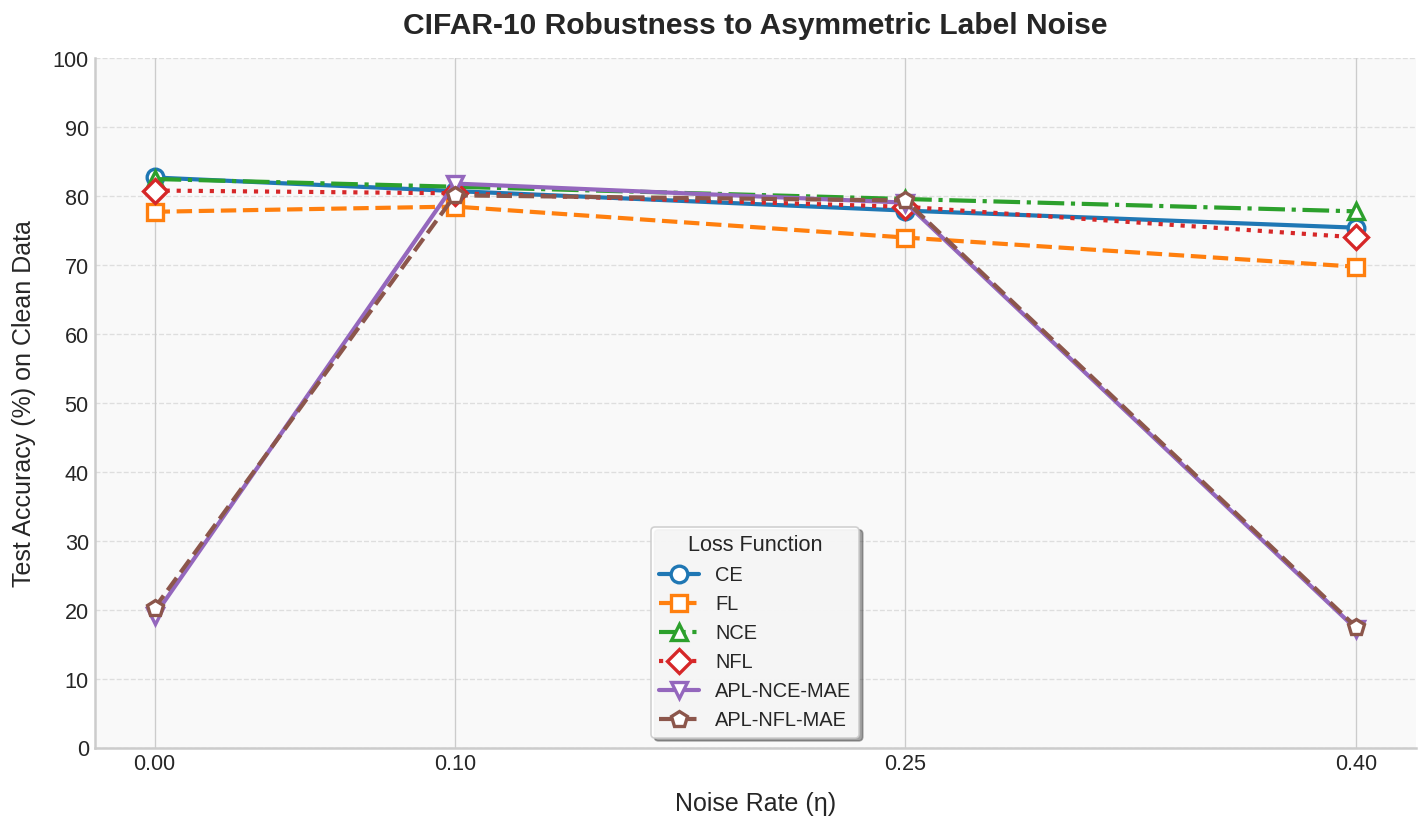


🎯 Plotting complete.


In [52]:
results_df = pd.read_csv("results.csv")

def plot_results(df, noise_type_filter, title):
    """
    Plots the test accuracy against noise rates for different loss functions under a specified noise type.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    
    plt.figure(figsize=(12, 7), dpi=120)
    
    filtered_df = df[df['Noise Type'] == noise_type_filter]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', 'p']
    
    loss_types = df['Loss Function'].unique()
    
    for i, loss_name in enumerate(loss_types):
        loss_df = filtered_df[filtered_df['Loss Function'] == loss_name].sort_values(by='Noise Rate')
        if not loss_df.empty:
            color = colors[i % len(colors)]
            
            plt.plot(
                loss_df['Noise Rate'], 
                loss_df['Test Accuracy'], 
                marker=markers[i % len(markers)],
                linestyle=line_styles[i % len(line_styles)],
                linewidth=2.5, 
                markersize=10,
                markeredgewidth=2,
                markerfacecolor='white',
                markeredgecolor=color,
                color=color,
                label=loss_name,
                zorder=5
            )
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    
    plt.title(title, fontsize=18, fontweight='bold', pad=15)
    plt.xlabel('Noise Rate (η)', fontsize=15, fontweight='medium', labelpad=10)
    plt.ylabel('Test Accuracy (%) on Clean Data', fontsize=15, fontweight='medium', labelpad=10)
    
    plt.legend(
        fontsize=12, 
        title="Loss Function",
        title_fontsize=13,
        frameon=True,
        fancybox=True,
        framealpha=0.9,
        shadow=True,
        loc='best'
    )
    
    plt.xticks(filtered_df['Noise Rate'].unique(), fontsize=13, fontweight='medium')
    plt.yticks(np.arange(0, 101, 10), fontsize=13, fontweight='medium')
    
    plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
    
    plt.ylim(bottom=0, top=100)
    
    plt.gca().set_facecolor('#f9f9f9')
    
    plt.tight_layout()
    plt.show()

    
if 'symmetric' in results_df['Noise Type'].values:
    plot_results(results_df, 'symmetric', 'CIFAR-10 Robustness to Symmetric Label Noise')

if 'asymmetric' in results_df['Noise Type'].values:
    plot_results(results_df, 'asymmetric', 'CIFAR-10 Robustness to Asymmetric Label Noise')

print("\n🎯 Plotting complete.")